In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN,MiniBatchKMeans,AgglomerativeClustering

import anndata as ad


In [2]:
ifplot=True
ifcluster=True
plottype='umap'
npc=40 #for pca plot
umapPC=None
clustermethod=['leiden','agglomerative','kmeanbatch']
# clustermethod=['leiden']
#tsne
perplexity=50
#umap/leiden clustering parameters
n_neighbors=10
min_dist=0.25
n_pcs=40 #for clustering
# resolution=[0.5,0.8,1,1.5,2,2.5,3]
# resolution=[2,2.5,3]
resolution=[0.05,0.1,0.2,0.3,0.5,0.8,1,1.5]
savenameAdd=''
#DBscan
epslist= [6,8,10]
min_sampleslist=[15,30,45] 
#agglomerative
nclusterlist=[2,3,4,5,8,10,15]
# nclusterlist=[15]
aggMetric=['euclidean']
minCells=15
pca=PCA()
tsne=TSNE(perplexity=perplexity)
plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
plot_sample_X=['corrected']
plotsavepath='/mnt/xinyi/pamrats/plots/data/'+plottype
seed=3
combineCelltype={'glia':['Astro','Micro', 'OPC', 'Oligo'],'CA':['CA1', 'CA2', 'CA3']}

maskedgeName='knn20_connectivity' #'knn20_connectivity'
adj_dir=os.path.join('/mnt/xinyi/','starmap','a')

In [3]:
#reproducing manuscript figure
# ifcluster=False
# umapPC=30
# n_neighbors=50
# min_dist=0.5


In [4]:
#Load data
scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-scaled.h5ad')

featureslist={}
if plot_sample_X[0] in ['corrected','scaled']:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-scaled.h5ad')
    
    for s in plot_samples.keys():
        featureslist[s+'X_'+'corrected']=(scaleddata.layers['corrected'][scaleddata.obs['sample']==plot_samples[s]])
        featureslist[s+'X_'+'scaled']=(scaleddata.layers['scaled'][scaleddata.obs['sample']==plot_samples[s]])
         if maskedgeName:
            adj_norm=preprocessing.preprocess_graph(sp.load_npz(os.path.join(adj_dir,maskedgeName+'_'+plot_samples[s]+'.npz')))
            adj_norm=adj_norm.to_dense().numpy()
            featureslist[s+'X_'+plot_sample_X[0]]=adj_norm @ adj_norm @ featureslist[s+'X_'+plot_sample_X[0]]
    
else:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
    
    for s in plot_samples.keys():
        scaleddata_train=scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]

        if plot_sample_X[0]=='logminmax':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler()
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+plot_sample_X[0]]=(featurelog_train_minmax)
        elif plot_sample_X[0]=='raw':
            featureslist[s+'X_'+plot_sample_X[0]]=(scaleddata_train)
        elif plot_sample_X[0]=='logminmaxGene':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler()
            featurelog_train_minmax=scaler.fit_transform(featurelog_train)
            featureslist[s+'X_'+plot_sample_X[0]]=(featurelog_train_minmax)
        if maskedgeName:
            adj_norm=preprocessing.preprocess_graph(sp.load_npz(os.path.join(adj_dir,maskedgeName+'_'+plot_samples[s]+'.npz')))
            adj_norm=adj_norm.to_dense().numpy()
            featureslist[s+'X_'+plot_sample_X[0]]=adj_norm @ adj_norm @ featureslist[s+'X_'+plot_sample_X[0]]

In [5]:
def plotembeddingbyCT(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd=''):
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1
        
    colortest=sns.color_palette("husl", celltypes.size)
#     np.random.shuffle(colortest)
    fig, ax = plt.subplots(dpi=400)
    for ct in celltypes:
        if ct in excludelist:
            continue
        idx=(ctlist==ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[celltypes_dict[ct]],label=ct,s=1.5,alpha=0.5
            )

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(5)
    fig.set_figwidth(5)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
#     ax.legend(ncol=3)
    plt.title(plotname+' embedding', fontsize=24)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'))
#     plt.show()
    
#     fig.clf()
    plt.close('all')
    
    
def plotembeddingbyCT_contrast(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd='',maxplot=None): 
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1

    colortest=sns.color_palette("tab10")
    if not os.path.exists(os.path.join(savepath)):
        os.makedirs(savepath)

    for ct in celltypes:
        if maxplot and int(ct)>maxplot:
            continue
        fig, ax = plt.subplots()
        if ct == 'Unassigned':
            continue

        idx=(ctlist!=ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[1],label='others',s=1,alpha=0.5
            )

        idx=(ctlist==ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[0],label=ct,s=3,alpha=0.5
            )

        plt.gca().set_aspect('equal', 'datalim')
        fig.set_figheight(10)
        fig.set_figwidth(10)
        ax.legend()
        plt.title(plotname+' embedding', fontsize=24)
        plt.gcf().savefig(os.path.join(savepath,savename+'_'+str(ct)+savenameAdd+'.jpg'))
#         plt.show()
#         nplot+=1
        
    
#         fig.clf()
        plt.close('all')


In [6]:
np.random.seed(seed)
def clusterLeiden_single(inArray,n_neighbors,n_pcs,min_dist,resolution,randseed=seed):
    n_pcs=np.min([inArray.shape[0]-1,inArray.shape[1]-1,n_pcs])
    adata=ad.AnnData(inArray)
    scanpy.tl.pca(adata, svd_solver='arpack')
    scanpy.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
    scanpy.tl.umap(adata,min_dist=min_dist,random_state=randseed)
    scanpy.tl.leiden(adata,resolution=resolution,random_state=randseed)
    return adata.obs['leiden'].to_numpy()

def clusterLeiden(inArray,n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np,randseed=seed):
    for r in resolution:
        clusterRes=clusterLeiden_single(inArray,n_neighbors,n_pcs,min_dist,r,randseed=seed)
#         print(clusterRes.shape)
        savenamecluster='leiden_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'n_pcs'+str(n_pcs)+'res'+str(r)
        with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
            pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
        plotembeddingbyCT(clusterRes,'leiden',[],embedding,savedir,plottype+' of '+s,savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'leiden',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+s,savenameAdd=savenamecluster)

        plotembeddingbyCT(clusterRes,'leiden_location',[],sobj_coord_np,savedir,'location'+' of '+s,savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'leiden_location',[],sobj_coord_np,os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster)

def clusterLeiden_allsample(inArray,n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np,samplenameList,randseed=seed):
    for r in resolution:
        clusterRes=clusterLeiden_single(inArray,n_neighbors,n_pcs,min_dist,r,randseed=seed)
        savenamecluster='leiden_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'n_pcs'+str(n_pcs)+'res'+str(r)
        with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
            pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
        plotembeddingbyCT(clusterRes,'leiden',[],embedding,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'leiden',[],embedding,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)

        for s in plot_samples.keys():
            sidx=(samplenameList==s)
            plotembeddingbyCT(clusterRes[sidx],'leiden_location'+s,[],sobj_coord_np[sidx],savedir,'location'+' of '+s,savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes[sidx],'leiden_location'+s,[],sobj_coord_np[sidx],os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster,maxplot=50)

def clusterDBscan_single(inArray,eps,min_samples,n_pcs):
    n_pcs=np.min([inArray.shape[0]-1,inArray.shape[1]-1,n_pcs])
    inArray=pca.fit_transform(inArray)
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(inArray[:,:n_pcs])
#     db = DBSCAN(eps=eps, min_samples=min_samples).fit(inArray[:,:n_pcs])
#     core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#     core_samples_mask[db.core_sample_indices_] = True
#     labels = db.labels_
    return labels

def clusterDBscan(inArray,epsL,min_samplesL,n_pcs,sobj_coord_np):
    for eps in epsL:
        for min_samples in min_samplesL:
            clusterRes=clusterDBscan_single(inArray,eps,min_samples,n_pcs)
    #         print(clusterRes.shape)
            savenamecluster='dbscan_eps'+str(eps)+'msamples'+str(min_samples)+'n_pcs'+str(n_pcs)
            with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
                pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
            plotembeddingbyCT(clusterRes,'dbscan',[],embedding,savedir,plottype+' of '+s,savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'dbscan',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+s,savenameAdd=savenamecluster)

            plotembeddingbyCT(clusterRes,'dbscan_location',[],sobj_coord_np,savedir,'location'+' of '+s,savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'dbscan_location',[],sobj_coord_np,os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster)

def clusterDBscan_allsample(inArray,epsL,min_samplesL,n_pcs,sobj_coord_np,samplenameList):
    for eps in epsL:
        for min_samples in min_samplesL:
            clusterRes=clusterDBscan_single(inArray,eps,min_samples,n_pcs)
            savenamecluster='dbscan_eps'+str(eps)+'msample'+str(min_samples)+'n_pcs'+str(n_pcs)
            with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
                pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
            plotembeddingbyCT(clusterRes,'dbscan',[],embedding,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'dbscan',[],embedding,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)

            for s in plot_samples.keys():
                sidx=(samplenameList==s)
                plotembeddingbyCT(clusterRes[sidx],'dbscan_location'+s,[],sobj_coord_np[sidx],savedir,'location'+' of '+s,savenameAdd=savenamecluster)
                plotembeddingbyCT_contrast(clusterRes[sidx],'dbscan_location'+s,[],sobj_coord_np[sidx],os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster,maxplot=50)

def clusterAgg_single(inArray,ncluster,aggmetric,n_pcs):
    n_pcs=np.min([inArray.shape[0]-1,inArray.shape[1]-1,n_pcs])
    inArray=pca.fit_transform(inArray)
    labels = AgglomerativeClustering(n_clusters=ncluster,affinity=aggmetric).fit_predict(inArray[:,:n_pcs])
#     labels = agg.labels_
    return labels

def clusterAgg(inArray,nclusterL,aggmetricL,n_pcs,sobj_coord_np):
    for ncluster in nclusterL:
        for aggmetric in aggmetricL:
            clusterRes=clusterAgg_single(inArray,ncluster,aggmetric,n_pcs)
    #         print(clusterRes.shape)
            savenamecluster='agg_ncluster'+str(ncluster)+aggmetric+'n_pcs'+str(n_pcs)
            with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
                pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
            plotembeddingbyCT(clusterRes,'agg',[],embedding,savedir,plottype+' of '+s,savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'agg',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+s,savenameAdd=savenamecluster)

            plotembeddingbyCT(clusterRes,'agg_location',[],sobj_coord_np,savedir,'location'+' of '+s,savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'agg_location',[],sobj_coord_np,os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster)

def clusterAgg_allsample(inArray,nclusterL,aggmetricL,n_pcs,sobj_coord_np,samplenameList):
    for ncluster in nclusterL:
        for aggmetric in aggmetricL:
            clusterRes=clusterAgg_single(inArray,ncluster,aggmetric,n_pcs)
            savenamecluster='agg_ncluster'+str(ncluster)+aggmetric+'n_pcs'+str(n_pcs)
            with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
                pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
            plotembeddingbyCT(clusterRes,'agg',[],embedding,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'agg',[],embedding,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)

            for s in plot_samples.keys():
                sidx=(samplenameList==s)
                plotembeddingbyCT(clusterRes[sidx],'agg_location'+s,[],sobj_coord_np[sidx],savedir,'location'+' of '+s,savenameAdd=savenamecluster)
                plotembeddingbyCT_contrast(clusterRes[sidx],'agg_location'+s,[],sobj_coord_np[sidx],os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster,maxplot=50)

def clusterMinibatchKmean_single(inArray,ncluster,n_pcs,batchsize=100):
    n_pcs=np.min([inArray.shape[0]-1,inArray.shape[1]-1,n_pcs])
    batchsize=int(np.min([(inArray.shape[0]-1)/3,(inArray.shape[1]-1)/3,batchsize]))
    inArray=pca.fit_transform(inArray)
    labels = MiniBatchKMeans(n_clusters=ncluster,random_state=seed,batch_size=batchsize).fit_predict(inArray[:,:n_pcs])
    return labels

def clusterMinibatchKmean(inArray,nclusterL,n_pcs,sobj_coord_np):
    for ncluster in nclusterL:
        clusterRes=clusterMinibatchKmean_single(inArray,ncluster,n_pcs)
#         print(clusterRes.shape)
        savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)
        with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
            pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
        plotembeddingbyCT(clusterRes,'minibatchkmean',[],embedding,savedir,plottype+' of '+s,savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'minibatchkmean',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+s,savenameAdd=savenamecluster)

        plotembeddingbyCT(clusterRes,'minibatchkmean_location',[],sobj_coord_np,savedir,'location'+' of '+s,savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'minibatchkmean_location',[],sobj_coord_np,os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster)

def clusterMinibatchKmean_allsample(inArray,nclusterL,n_pcs,sobj_coord_np,samplenameList):
    for ncluster in nclusterL:
        clusterRes=clusterMinibatchKmean_single(inArray,ncluster,n_pcs)
        savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)
        with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
            pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
        plotembeddingbyCT(clusterRes,'minibatchkmean',[],embedding,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'minibatchkmean',[],embedding,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)

        for s in plot_samples.keys():
            sidx=(samplenameList==s)
            plotembeddingbyCT(clusterRes[sidx],'minibatchkmean_location'+s,[],sobj_coord_np[sidx],savedir,'location'+' of '+s,savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes[sidx],'minibatchkmean_location'+s,[],sobj_coord_np[sidx],os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster,maxplot=50)

                       

In [7]:
for s in plot_samples.keys():
    sampleidx=plot_samples[s]
    celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']
    celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']
    region=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']
    sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()
    for xcorr in plot_sample_X:
        samplename=s+'X_'+xcorr
        features=featureslist[samplename]
        savedir=os.path.join(plotsavepath,samplename+maskedgeName)
        clustersavedir=os.path.join(plotsavepath,samplename+maskedgeName,'cluster')
        if not os.path.exists(savedir):
            os.mkdir(savedir)
        if not os.path.exists(clustersavedir):
            os.mkdir(clustersavedir)
        
        if plottype=='umap':
            reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
            embedding = reducer.fit_transform(features)
        elif plottype=='pca':
            pca.fit(features)
            fig, ax = plt.subplots(dpi=400)
            fig.set_figheight(2.5)
            fig.set_figwidth(10)
            plt.bar(np.arange(npc),pca.explained_variance_ratio_[:npc])
            plt.savefig(os.path.join(savedir,'varRatio_'+str(npc)+'.jpg'))
            embedding=pca.transform(features)
        elif plottype =='tsne':
            embedding=tsne.fit_transform(features)
            savenameAdd='_perp'+str(perplexity)
        
        plotembeddingbyCT(celltype_broad,'celltype_broad',[],embedding,savedir,plottype+' of '+s,savenameAdd=savenameAdd)
#         plotembeddingbyCT(celltype_sub,'celltype_sub',[],embedding,savedir,plottype+' of '+s)
        plotembeddingbyCT(region,'region',[],embedding,savedir,plottype+' of '+s,savenameAdd=savenameAdd)
        
        plotembeddingbyCT_contrast(celltype_sub,'celltype_sub',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+s)
        if ifcluster:
            if 'leiden' in clustermethod:
                clusterLeiden(features,n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np,randseed=seed)
            if 'dbscan' in clustermethod:
                clusterDBscan(features,epslist,min_sampleslist,n_pcs,sobj_coord_np)
            if 'agglomerative' in clustermethod:
                clusterAgg(features,nclusterlist,aggMetric,n_pcs,sobj_coord_np)
            if 'kmeanbatch' in clustermethod:
                clusterMinibatchKmean(features,nclusterlist,n_pcs,sobj_coord_np)


In [8]:
savedir

'/mnt/xinyi/pamrats/plots/data/umap/control8X_correctedknn20_connectivity'

In [9]:
pca.fit(featureslist['control13X_scaled'])


PCA()

In [10]:
np.sum(pca.explained_variance_ratio_>=(pca.explained_variance_ratio_[0]*0.1))

58

In [11]:
featureraw=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')

In [12]:
featureraw_control13=featureraw.X[featureraw.obs['sample']=='AD_mouse9498']

In [13]:
pca.fit(featureraw_control13)

PCA()

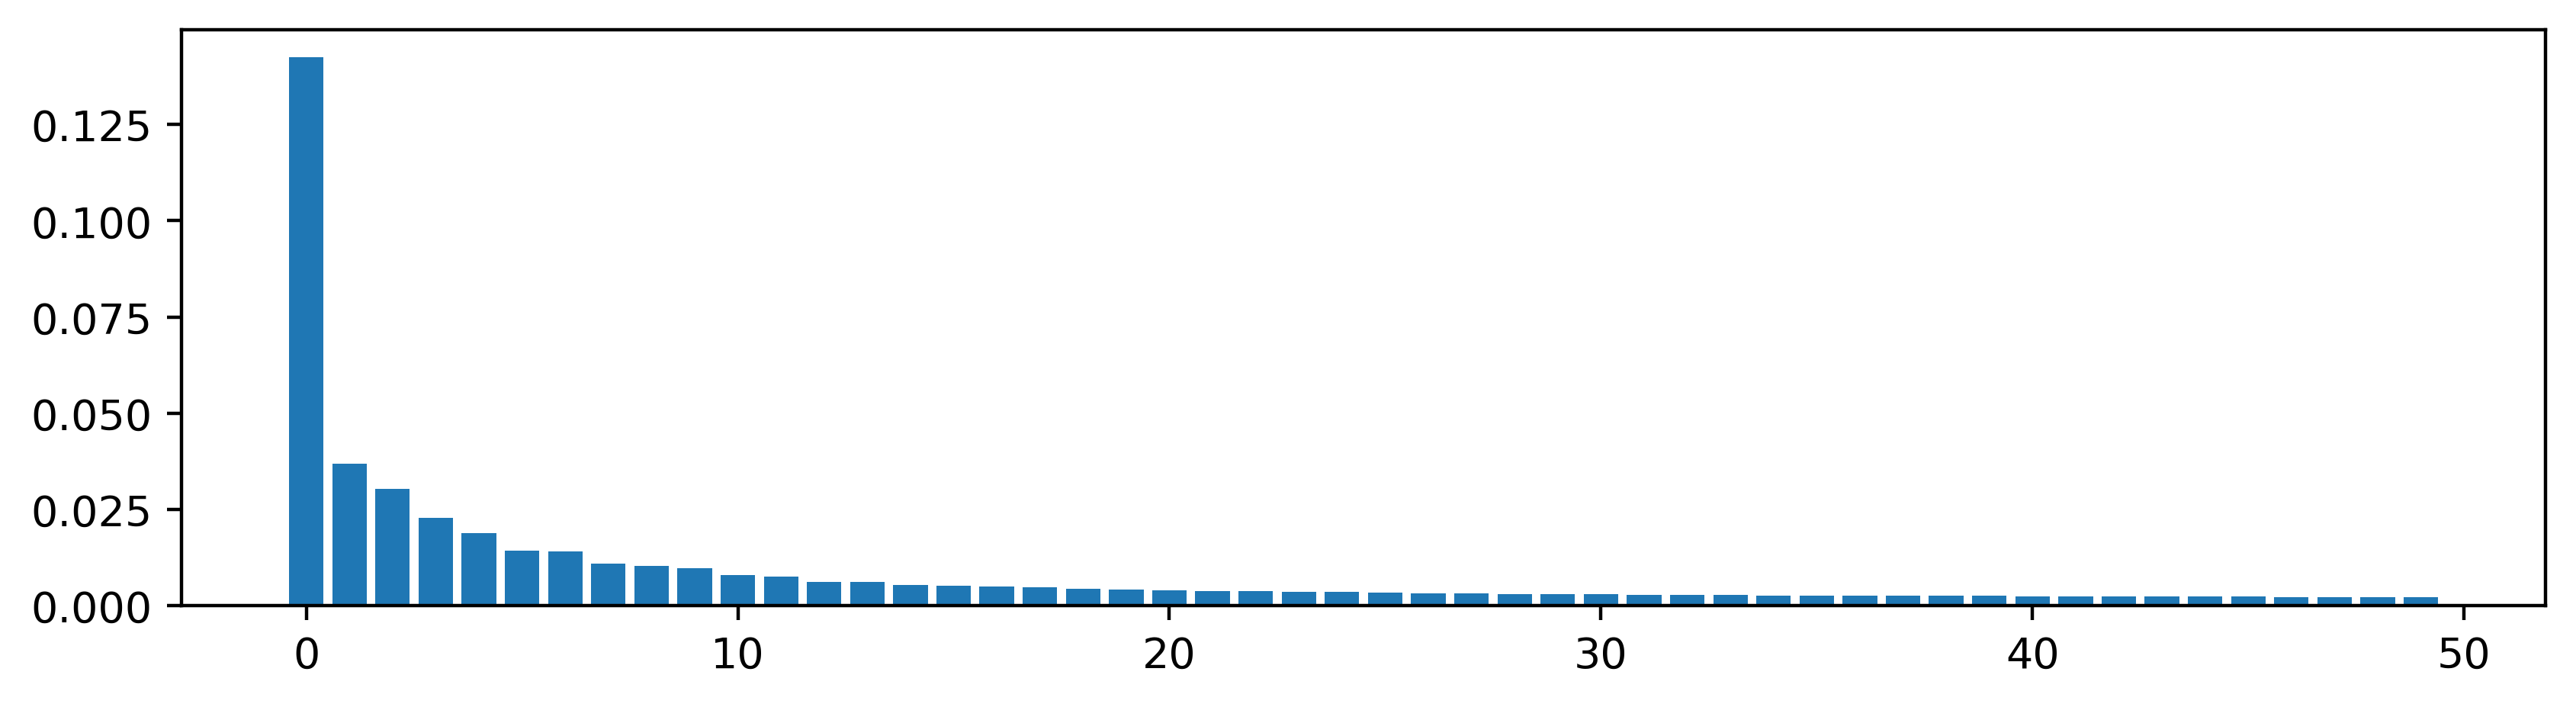

In [14]:
npc=50
savedir=os.path.join(plotsavepath,'control13X_raw')
fig, ax = plt.subplots(dpi=400)
fig.set_figheight(2.5)
fig.set_figwidth(10)
plt.bar(np.arange(npc),pca.explained_variance_ratio_[:npc])
plt.savefig(os.path.join(savedir,'varRatio_'+str(npc)+'.jpg'))

In [15]:
pca.explained_variance_ratio_[0]

0.14249311

In [16]:
np.sum(pca.explained_variance_ratio_>=(pca.explained_variance_ratio_[0]*0.75))

1

log2(x+1/2)

In [17]:
featurelog_control13=np.log2(featureraw_control13+1/2)

In [18]:
pca.fit(featurelog_control13)

PCA()

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/xinyi/pamrats/plots/data/umap/control13X_log/varRatio_50.jpg'

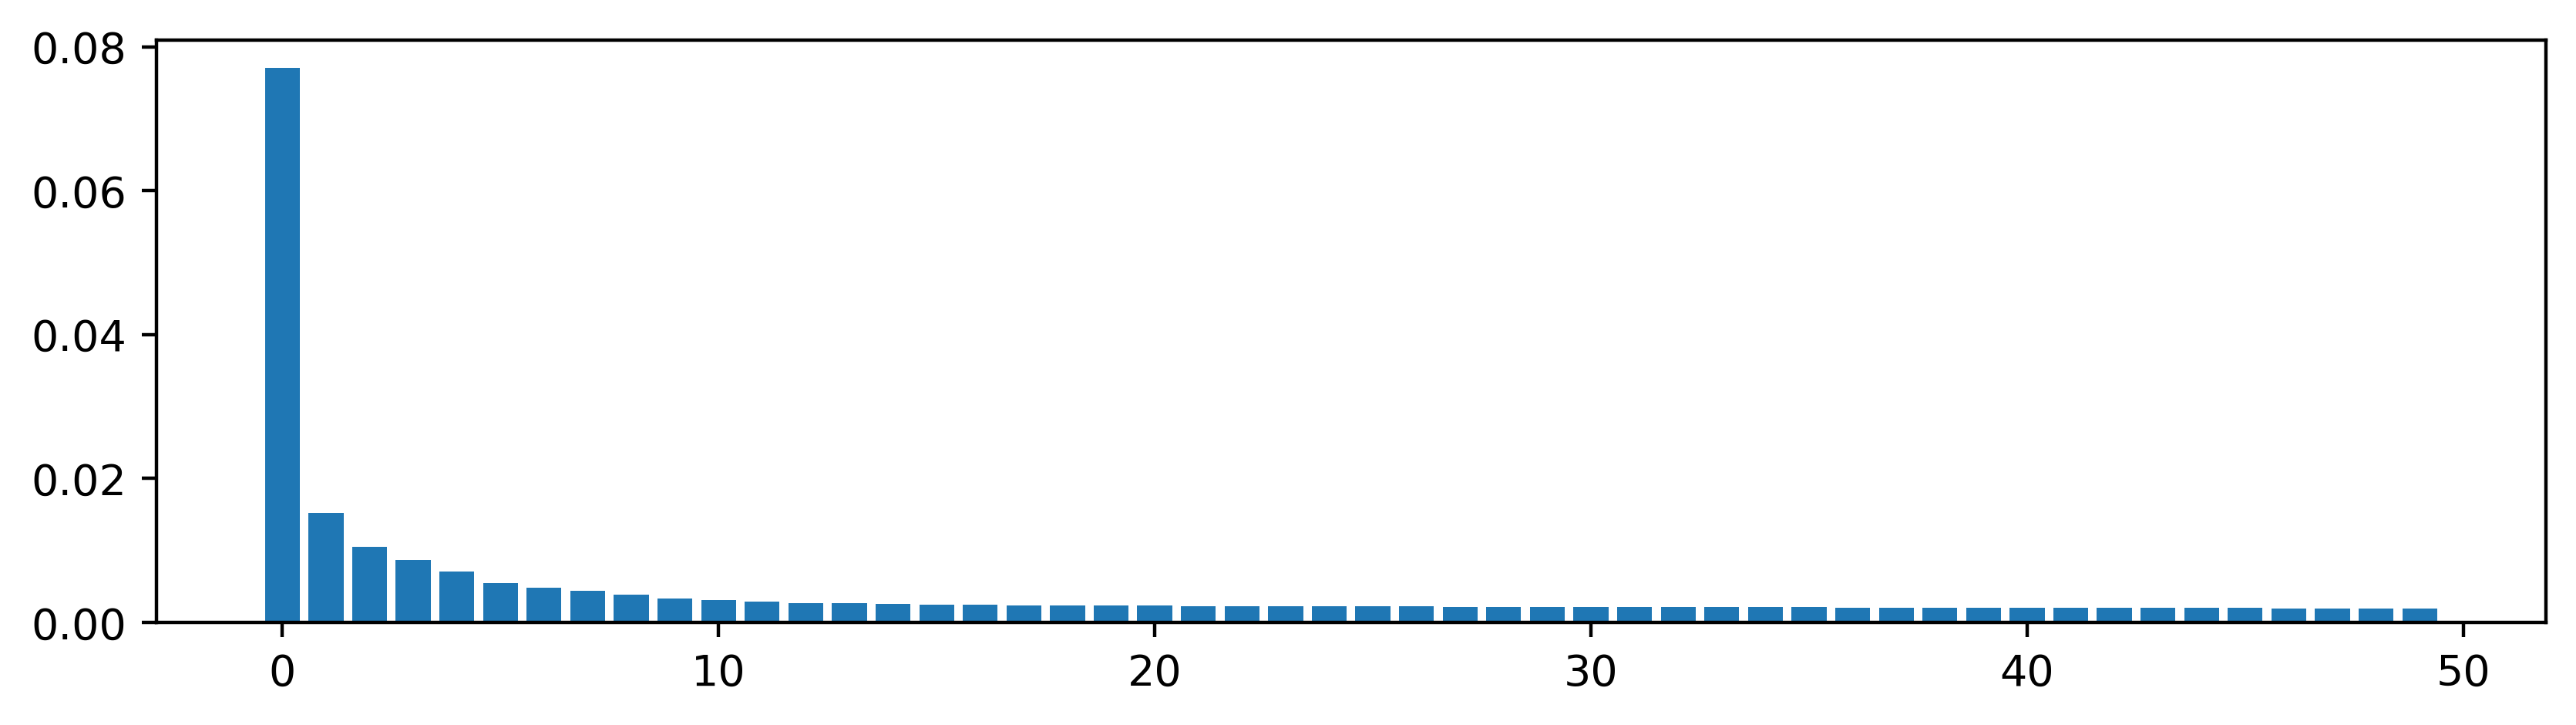

In [19]:
npc=50
savedir=os.path.join(plotsavepath,'control13X_log')
fig, ax = plt.subplots(dpi=400)
fig.set_figheight(2.5)
fig.set_figwidth(10)
plt.bar(np.arange(npc),pca.explained_variance_ratio_[:npc])
plt.savefig(os.path.join(savedir,'varRatio_'+str(npc)+'.jpg'))

In [ ]:
pca.explained_variance_ratio_[0]

In [ ]:
np.sum(pca.explained_variance_ratio_>=(pca.explained_variance_ratio_[0]*0.005))

+ min max

In [ ]:
scaler = MinMaxScaler()
featurelog_control13_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_control13)))

In [ ]:
pca.fit(featurelog_control13_minmax)

In [ ]:
npc=500
savedir=os.path.join(plotsavepath,'control13X_logminmax')
fig, ax = plt.subplots(dpi=400)
fig.set_figheight(2.5)
fig.set_figwidth(10)
plt.bar(np.arange(npc),pca.explained_variance_ratio_[:npc])
plt.savefig(os.path.join(savedir,'varRatio_'+str(npc)+'.jpg'))

In [ ]:
pca.explained_variance_ratio_[0]

In [ ]:
np.sum(pca.explained_variance_ratio_>=(pca.explained_variance_ratio_[0]*0.05))

log2(10^4*x/libsize+1/2)

In [ ]:
sum_of_rows = featureraw_control13.sum(axis=1)
featureloglibnorm_control13=np.log2(featureraw_control13/ sum_of_rows[:, np.newaxis]*10000+1/2)

In [ ]:
pca.fit(featureloglibnorm_control13)

In [ ]:
npc=500
savedir=os.path.join(plotsavepath,'control13X_loglibnorm')
fig, ax = plt.subplots(dpi=400)
fig.set_figheight(2.5)
fig.set_figwidth(10)
plt.bar(np.arange(npc),pca.explained_variance_ratio_[:npc])
plt.savefig(os.path.join(savedir,'varRatio_'+str(npc)+'.jpg'))

In [ ]:
pca.explained_variance_ratio_[0]

In [ ]:
np.sum(pca.explained_variance_ratio_>=(pca.explained_variance_ratio_[0]*0.05))

+ min max by cell

In [ ]:
scaler = MinMaxScaler()
featureloglibnorm_control13_minmax=np.transpose(scaler.fit_transform(np.transpose(featureloglibnorm_control13)))

In [ ]:
pca.fit(featureloglibnorm_control13_minmax)

In [ ]:
npc=500
savedir=os.path.join(plotsavepath,'control13X_loglibnorm_minmax')
fig, ax = plt.subplots(dpi=400)
fig.set_figheight(2.5)
fig.set_figwidth(10)
plt.bar(np.arange(npc),pca.explained_variance_ratio_[:npc])
plt.savefig(os.path.join(savedir,'varRatio_'+str(npc)+'.jpg'))

In [ ]:
pca.explained_variance_ratio_[0]

In [ ]:
np.sum(pca.explained_variance_ratio_>=(pca.explained_variance_ratio_[0]*0.05))

In [ ]:
plot_sample_X=['logminmax']
featureslist={}
if plot_sample_X[0] in ['corrected','scaled']:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-scaled.h5ad')
    
    featureslist['corrected']=scaleddata.layers['corrected']
    featureslist['scaled']=scaleddata.layers['scaled']
    
else:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
    
    for s in plot_samples.keys():
        scaleddata_train=scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]

        if plot_sample_X[0]=='logminmax':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler()
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]=featurelog_train_minmax
    featureslist['logminmax']=scaleddata

In [ ]:
scanpy.pp.highly_variable_genes(featureslist['logminmax'],n_top_genes=50)

In [ ]:
for g in featureslist['logminmax'].var_names[featureslist['logminmax'].var['highly_variable']]:
    scanpy.pl.violin(featureslist['logminmax'],keys=g,groupby='sample')

In [7]:
#for testing: combine latent of some samples

# ifcluster=True
# ifplot=True
for xcorr in plot_sample_X:
    latents=None
    celltype_broad=None
    celltype_sub=None
    region=None
    samplenameList=None
    sobj_coord_np=None
    
    for s in plot_samples.keys():
        sampleidx=plot_samples[s]        
        samplename=s+'X_'+xcorr
        muplot=np.copy(featureslist[samplename])
            
        if latents is None:
            latents=muplot
            celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']
            celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']
            region=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']
            sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()
            samplenameList=np.repeat(s,muplot.shape[0])
        else:
            latents=np.vstack((latents,muplot))
            celltype_broad=np.concatenate((celltype_broad,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']),axis=None)
            celltype_sub=np.concatenate((celltype_sub,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']),axis=None)
            region=np.concatenate((region,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']),axis=None)
            sobj_coord_np=np.concatenate((sobj_coord_np,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()),axis=0)
            samplenameList=np.concatenate((samplenameList,np.repeat(s,muplot.shape[0])),axis=None)
       
    origCT=np.unique(celltype_broad)
    celltypeplot=np.concatenate((origCT,list(combineCelltype.keys())),axis=None)
    sampledir=os.path.join(plotsavepath,'combined'+xcorr+maskedgeName)
    savedir=os.path.join(sampledir,'embedding_'+plottype)
    clustersavedir=os.path.join(sampledir,'cluster')
    if not os.path.exists(sampledir):
        os.mkdir(sampledir)
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    if not os.path.exists(clustersavedir):
        os.mkdir(clustersavedir)
    
    if plottype=='umap':
        if umapPC:
            latentsplot=pca.fit_transform(latents)[:,:umapPC]
        else:
            latentsplot=latents
        reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
        embedding = reducer.fit_transform(latentsplot)
        savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))
        if umapPC:
            savenameAdd=savenameAdd+"_umapPC"+str(umapPC)
    elif plottype=='pca':
        embedding=pca.fit_transform(latents)
        savenameAdd=''
    elif plottype =='tsne':
        embedding=tsne.fit_transform(latents)
        savenameAdd='_perp'+str(perplexity)
    
    if ifplot:
        plotembeddingbyCT(samplenameList,'sample',[],embedding,savedir,plottype+'of all samples',savenameAdd=savenameAdd)
        plotembeddingbyCT(celltype_broad,'celltype_broad',[],embedding,savedir,plottype+'all samples',savenameAdd=savenameAdd)
        plotembeddingbyCT(celltype_sub,'celltype_sub',[],embedding,savedir,plottype+'all samples',savenameAdd=savenameAdd)
        plotembeddingbyCT(region,'region',[],embedding,savedir,plottype+'all samples',savenameAdd=savenameAdd)

        plotembeddingbyCT_contrast(celltype_sub,'celltype_sub',[],embedding,os.path.join(savedir,'contrast'),plottype+'all samples',savenameAdd=savenameAdd)    
    
    if embedding.shape[0]<minCells:
        continue
    if ifcluster:
        if 'leiden' in clustermethod:
            clusterLeiden_allsample(latents,n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np,samplenameList,randseed=seed)
        if 'dbscan' in clustermethod:
            clusterDBscan_allsample(latents,epslist,min_sampleslist,n_pcs,sobj_coord_np,samplenameList)
        if 'agglomerative' in clustermethod:
            clusterAgg_allsample(latents,nclusterlist,aggMetric,n_pcs,sobj_coord_np,samplenameList)
        if 'kmeanbatch' in clustermethod:
            clusterMinibatchKmean_allsample(latents,nclusterlist,n_pcs,sobj_coord_np,samplenameList)
    #by region
    for reg in np.unique(region):
        savedir=os.path.join(sampledir,'embedding_'+plottype+'_'+reg)
        clustersavedir=os.path.join(sampledir,'cluster'+'_'+reg)
        if not os.path.exists(savedir):
            os.mkdir(savedir)
        if not os.path.exists(clustersavedir):
            os.mkdir(clustersavedir)

        reg_idx=region==reg

#         if plottype=='umap':
#             reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
#             embedding = reducer.fit_transform(latents[reg_idx])
#             savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))
#         elif plottype=='pca':
#             embedding=pca.fit_transform(latents[reg_idx])
#             savenameAdd=''
#         if ifplot:
#             plotembeddingbyCT(samplenameList[reg_idx],'sample',[],embedding,savedir,plottype+' of '+'all samples'+' '+reg,savenameAdd=savenameAdd)
#             plotembeddingbyCT(celltype_broad[reg_idx],'celltype_broad',[],embedding,savedir,plottype+' of '+'all samples'+' '+reg,savenameAdd=savenameAdd)
#             plotembeddingbyCT(celltype_sub[reg_idx],'celltype_sub',[],embedding,savedir,plottype+' of '+'all samples'+' '+reg,savenameAdd=savenameAdd)
#     #             plotembeddingbyCT(region,'region',[],embedding[reg_idx],savedir,'UMAP of '+s)

#             plotembeddingbyCT_contrast(celltype_sub[reg_idx],'celltype_sub',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+'all samples'+' '+reg,savenameAdd=savenameAdd)
        
#         if embedding.shape[0]<minCells:
#             continue
#         if ifcluster:
#             if 'leiden' in clustermethod:
#                 clusterLeiden_allsample(latents[reg_idx],n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np[reg_idx],samplenameList[reg_idx],randseed=seed)
#                 assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
#             if 'dbscan' in clustermethod:
#                 clusterDBscan_allsample(latents[reg_idx],epslist,min_sampleslist,n_pcs,sobj_coord_np[reg_idx],samplenameList[reg_idx])
#                 assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
#             if 'agglomerative' in clustermethod:
#                 clusterAgg_allsample(latents[reg_idx],nclusterlist,aggMetric,n_pcs,sobj_coord_np[reg_idx],samplenameList[reg_idx])
#                 assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
#             if 'kmeanbatch' in clustermethod:
#                 clusterMinibatchKmean_allsample(latents[reg_idx],nclusterlist,n_pcs,sobj_coord_np[reg_idx],samplenameList[reg_idx])
#                 assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
        #by region and celltype
        for ct in celltypeplot:
#             if not ( ct in ['Micro']):
#             if not ((reg=='Cortex' and ct in ['Ex']) or (reg=='Hippocampus' and ct in ['CA1','DG','Micro'])):
            if not ((reg=='Hippocampus' and ct in ['CA1','Micro'])):
                continue
            print(reg+ct)
            savedir=os.path.join(sampledir,'embedding_'+plottype+'_'+reg+ct)
            clustersavedir=os.path.join(sampledir,'cluster'+'_'+reg+ct)
            if not os.path.exists(savedir):
                os.mkdir(savedir)
            if not os.path.exists(clustersavedir):
                os.mkdir(clustersavedir)

            
            if ct in origCT:
                ct_idx=celltype_broad==ct
            else:
                ct_idx=False
                for i in combineCelltype[ct]:
                    ct_idx=np.logical_or(ct_idx,celltype_broad==i)
            ct_idx=np.logical_and(reg_idx,ct_idx)      
            
            if np.sum(ct_idx)<3:
                continue
            if plottype=='umap':
                reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
                embedding = reducer.fit_transform(latents[ct_idx])
                savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))
            elif plottype=='pca':
                embedding=pca.fit_transform(latents[ct_idx])
                savenameAdd=''
                
            if ifplot:
                plotembeddingbyCT(samplenameList[ct_idx],'sample',[],embedding,savedir,plottype+' of '+reg+' all samples'+' '+ct,savenameAdd=savenameAdd)
        #         plotembeddingbyCT(celltype_broad[reg_idx],'celltype_broad',[],embedding,savedir,plottype+' of '+'all samples'+' '+reg)
                plotembeddingbyCT(celltype_sub[ct_idx],'celltype_sub',[],embedding,savedir,plottype+' of '+reg+' all samples'+' '+ct,savenameAdd=savenameAdd)
    #             plotembeddingbyCT(region[ct_idx],'region',[],embedding,savedir,plottype+' of '+reg+' all samples'+' '+ct)

                plotembeddingbyCT_contrast(celltype_sub[ct_idx],'celltype_sub',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+reg+' all samples'+' '+ct,savenameAdd=savenameAdd)
        
            if embedding.shape[0]<minCells:
                continue
            if ifcluster:
                if 'leiden' in clustermethod:
                    clusterLeiden_allsample(latents[ct_idx],n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np[ct_idx],samplenameList[ct_idx],randseed=seed)
                if 'dbscan' in clustermethod:
                    clusterDBscan_allsample(latents[ct_idx],epslist,min_sampleslist,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])
                if 'agglomerative' in clustermethod:
                    clusterAgg_allsample(latents[ct_idx],nclusterlist,aggMetric,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])
                if 'kmeanbatch' in clustermethod:
                    clusterMinibatchKmean_allsample(latents[ct_idx],nclusterlist,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])
    

HippocampusCA1
HippocampusMicro


In [ ]:
# ifcluster=True
# separate plots by region and cell types
np.random.seed(seed)
for s in plot_samples.keys():
#     if s in ['disease13']:
#         continue
    print(s)
    sampleidx=plot_samples[s]
    celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']
    celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']
    region=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']
    sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()
    
    origCT=np.unique(celltype_broad)
    celltypeplot=np.concatenate((origCT,list(combineCelltype.keys())),axis=None)
    for xcorr in plot_sample_X:
        samplename=s+'X_'+xcorr
        muplot=np.copy(featureslist[samplename])

        sampledir=os.path.join(plotsavepath,samplename+maskedgeName)
        if not os.path.exists(sampledir):
            os.mkdir(sampledir)
            
        for r in np.unique(region):
            print(r)
            ridx=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']==r
            for reg in celltypeplot:
#                 if not ((r=='Cortex' and reg in ['Ex']) or (r=='Hippocampus' and reg in ['CA1','DG','Micro'])):
#                     continue
                if not ((r=='Cortex' and reg in ['Ex']) or (r=='Hippocampus' and reg in ['CA1'])):
                    continue
#                 if s=='disease8' and r=='Cortex' and (reg in ['Astro','CA1','CA2','CA3','DG','Endo','Ex','Inhi','LHb','Micro','OPC','Oligo','SMC']):
#                     continue
                print(reg)
                savedir0=os.path.join(sampledir,'embedding_'+plottype+'_'+reg)
                savedir=os.path.join(sampledir,'embedding_'+plottype+'_'+reg,r)
                clustersavedir0=os.path.join(sampledir,'cluster'+'_'+reg)
                clustersavedir=os.path.join(sampledir,'cluster'+'_'+reg,r)
                if not os.path.exists(savedir0):
                    os.mkdir(savedir0)
                if not os.path.exists(savedir):
                    os.mkdir(savedir)
                if not os.path.exists(clustersavedir0):
                    os.mkdir(clustersavedir0)
                if not os.path.exists(clustersavedir):
                    os.mkdir(clustersavedir)

                if reg in origCT:
                    ct_idx=celltype_broad==reg
                else:
                    ct_idx=False
                    for i in combineCelltype[reg]:
                        ct_idx=np.logical_or(ct_idx,celltype_broad==i)
                
                reg_idx=np.logical_and(ridx,ct_idx)
                if np.sum(reg_idx)<=3:
                    print('skipped')
                    continue
                
                if plottype=='umap':
                    reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
                    embedding = reducer.fit_transform(muplot[reg_idx])
                    savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))
                elif plottype=='pca':
                    embedding=pca.fit_transform(muplot[reg_idx])
                    savenameAdd=''
                if ifplot:
    #                 plotembeddingbyCT(celltype_broad[reg_idx],'celltype_broad_'+r,[],embedding,savedir,plottype+' of '+r+' '+s+' '+reg)
                    plotembeddingbyCT(celltype_sub[reg_idx],'celltype_sub_'+r,[],embedding,savedir,plottype+' of '+r+' '+s+' '+reg,savenameAdd=savenameAdd)
        #             plotembeddingbyCT(region,'region',[],embedding[reg_idx],savedir,s)
                    plotembeddingbyCT_contrast(celltype_sub[reg_idx],'celltype_sub_'+r,[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+r+' '+s+' '+reg,savenameAdd=savenameAdd)
                    
#                     plotembeddingbyCT(celltype_sub[reg_idx],'celltype_sub_location_'+r,[],sobj_coord_np[reg_idx],savedir,'location'+' of '+r+' '+s,savenameAdd='')

                if embedding.shape[0]<minCells:
                    continue
                if ifcluster:
                    if 'leiden' in clustermethod:
                        clusterLeiden(muplot[reg_idx],n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np[reg_idx],randseed=seed)
                    if 'dbscan' in clustermethod:
                        clusterDBscan(muplot[reg_idx],epslist,min_sampleslist,n_pcs,sobj_coord_np[reg_idx])
                    if 'agglomerative' in clustermethod:
                        clusterAgg(muplot[reg_idx],nclusterlist,aggMetric,n_pcs,sobj_coord_np[reg_idx])
                    if 'kmeanbatch' in clustermethod:
                        clusterMinibatchKmean(muplot[reg_idx],nclusterlist,n_pcs,sobj_coord_np[reg_idx])
